# Código Base
link: https://goodboychan.github.io/python/tensorflow/mit/2021/02/14/music-generation.html

## Music Generation with RNNs

In [55]:
import tensorflow as tf 
import numpy as np
import os
import time
import regex as re
import subprocess
import urllib
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

## Dataset

In [29]:
cwd = os.getcwd()

def extract_song_snippet(text):
    pattern = '(^|\n\n)(.*?)\n\n'
    search_results = re.findall(pattern, text, overlapped=True, flags=re.DOTALL)
    songs = [song[1] for song in search_results]
    print("Found {} songs in text".format(len(songs)))
    return songs

songs = []

with open(os.path.join(cwd, 'irish', 'irish.abc'), 'r') as f:
    text = f.read()
    songs = extract_song_snippet(text)
    
# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [30]:
def save_song_to_abc(song, filename="tmp"):
    save_name = "{}.abc".format(filename)
    with open(save_name, "w") as f:
        f.write(song)
    return filename

def abc2wav(abc_file):
    suf = abc_file.rstrip('.abc')
    cmd = "abc2midi {} -o {}".format(abc_file, suf + ".mid")
    os.system(cmd)
    cmd = "timidity {}.mid -Ow {}.wav".format(suf, suf)
    return os.system(cmd) 

def play_wav(wav_file):
    return ipythondisplay.Audio(wav_file)

def play_song(song):
    basename = save_song_to_abc(song)
    ret = abc2wav(basename + '.abc')
    if ret == 0: #did not suceed
        return play_wav(basename+'.wav')
    return None

In [31]:
songs_joined = "\n\n".join(songs) 

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


## Process the dataset for the learning task

In [32]:
# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
#   we can evaluate `char2idx["d"]`.  
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

In [33]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [34]:
'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping
    above to convert from vocab characters to the corresponding indices.

    NOTE: the output of the `vectorize_string` function 
    should be a np.array with `N` elements, where `N` is
    the number of characters in the input string
'''

def vectorize_string(string):
    vectorized_list = np.array([char2idx[s] for s in string])
    return vectorized_list

vectorized_songs = vectorize_string(songs_joined)

In [35]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


## Create training examples and targets

In [36]:
def test_batch_func_types(func, args):
    ret = func(*args)
    assert len(ret) == 2, "[FAIL] get_batch must return two arguments (input and label)"
    assert type(ret[0]) == np.ndarray, "[FAIL] test_batch_func_types: x is not np.array"
    assert type(ret[1]) == np.ndarray, "[FAIL] test_batch_func_types: y is not np.array"
    print("[PASS] test_batch_func_types")
    return True

def test_batch_func_shapes(func, args):
    dataset, seq_length, batch_size = args
    x, y = func(*args)
    correct = (batch_size, seq_length)
    assert x.shape == correct, "[FAIL] test_batch_func_shapes: x {} is not correct shape {}".format(x.shape, correct)
    assert y.shape == correct, "[FAIL] test_batch_func_shapes: y {} is not correct shape {}".format(y.shape, correct)
    print("[PASS] test_batch_func_shapes")
    return True

def test_batch_func_next_step(func, args):
    x, y = func(*args)
    assert (x[:,1:] == y[:,:-1]).all(), "[FAIL] test_batch_func_next_step: x_{t} must equal y_{t-1} for all t"
    print("[PASS] test_batch_func_next_step")
    return True

In [37]:
def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  '''TODO: construct a list of input sequences for the training batch'''
  input_batch = [vectorized_songs[i:i+seq_length] for i in idx]
  '''TODO: construct a list of output sequences for the training batch'''
  output_batch = [vectorized_songs[i+1: i+1+seq_length] for i in idx]

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly! 
test_args = (vectorized_songs, 10, 2)
if not test_batch_func_types(get_batch, test_args) or \
   not test_batch_func_shapes(get_batch, test_args) or \
   not test_batch_func_next_step(get_batch, test_args): 
   print("======\n[FAIL] could not pass tests")
else: 
   print("======\n[PASS] passed all tests!")


[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [38]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 14 ('2')
  expected output: 60 ('e')
Step   1
  input: 60 ('e')
  expected output: 27 ('B')
Step   2
  input: 27 ('B')
  expected output: 1 (' ')
Step   3
  input: 1 (' ')
  expected output: 58 ('c')
Step   4
  input: 58 ('c')
  expected output: 26 ('A')


## The Recurrent Neural Network (RNN) model

### Define the RNN model

In [39]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [40]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    LSTM(rnn_units),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    tf.keras.layers.Dense(units=vocab_size)
  ])

  return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

### Test out the model

In [41]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (32, None, 256)           21248     
_________________________________________________________________
lstm_3 (LSTM)                (32, None, 1024)          5246976   
_________________________________________________________________
dense_3 (Dense)              (32, None, 83)            85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [42]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


### Prediction from the untrained model

In [43]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([50,  5, 64, 57, 11, 55,  7, 75, 55, 12, 11, 23, 28, 13, 21, 55, 29,
       73, 79, 54, 71, 46, 53, 47, 10, 46, 10, 74,  2, 40, 79, 73,  9, 81,
       13, 74, 70, 19, 47, 65, 28,  7, 53, 62, 38, 79, 66, 19, 11, 67, 51,
       22, 50, 75, 29, 40, 80, 41, 51, 63, 12, 67, 41, 53, 27, 61, 18, 71,
       16, 58, 51, 74, 37, 32, 34, 19,  1, 60, 11,  6, 72, 24, 70, 19, 59,
       74, 47,  4, 18, 30, 26, 79, 24, 21, 41, 20, 48, 49, 50, 17],
      dtype=int64)

In [44]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 '|!\ne|f3e fede|fedB ABde|f3e fede|fgaf efde|!\nf2af efde|fedB ABde|f2ed BdAd|egfe d3:|!\n\nX:192\nT:Lady '

Next Char Predictions: 
 "Y'ib/_)t_0/<C19_Drx^pU]V.U.s!Oxr-z1so7VjC)]gMxk7/lZ:YtDOyPZh0lP]Bf6p4cZsLGI7 e/(q=o7dsV#6EAx=9P8WXY5"


### Training the model: loss and training operations

In [45]:
'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

'''TODO: compute the loss using the true next characters from the example batch 
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred) 

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.41936


In [46]:
# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [47]:
class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

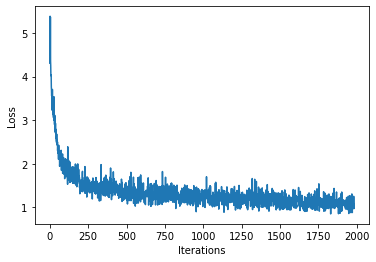

100%|██████████| 2000/2000 [02:05<00:00, 15.99it/s]


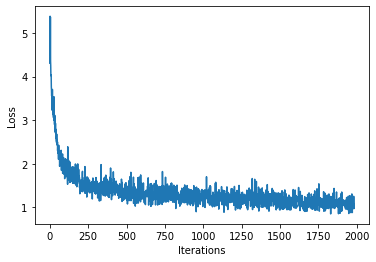

In [48]:
'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)
  
    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

## Generate music using the RNN model

### Restore the latest checkpoint

In [49]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
lstm_5 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_5 (Dense)              (1, None, 83)             85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


### The prediction procedure

In [50]:
def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id])
    
  return (start_string + ''.join(text_generated))

In [56]:
'''TODO: Use the model and the function defined above to generate ABC format text of length 1000!
    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO

100%|██████████| 1000/1000 [00:05<00:00, 173.37it/s]


In [57]:
generated_songs = extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  waveform = play_song(song)

  # If its a valid song (correct syntax), lets play it! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

Found 3 songs in text


In [61]:
print(generated_text)

X:1/8
L:1/8
K:A Major
(3DEF|G2Bd edBd|cAGE D3B|cAdc BAAG|E2F EFD|!
EDC EFF|BAF B2A GED|GFG AFG|!
A2D dBA|B2e e2f|e2BA BAE2:|!

X:17
T:Blackshornpert's Caly Fishertt
Z: id:dc-reel-151
M:C
L:1/8
K:G Major
D|G2GB AGEG|DEGA BGGF|GABd egdB|cDBE cBAcBd|!
efg a2g|fed edc|cAA eAA|!
GBG G2B|AGA BGE|D2A A2G ege d2f|!
g2B GAB|dgg BdB|GAB cBA|!
Gdd dBG|ded e2d|cAB G3|E3 E2D|!
BAG A3:|!
eaa aba|bga gdB|A3:|!
Add Add|fdd edd|gdB cBA|GAB cAd|!
gBB d2A|dBA AGA|BAB GBe|cAF GFE|D3:|!
DED FA|D/F/E/G/F/E/|D4 E:|!
A,|EF GF/E/|D^CEF F2GF|DFAF DEFGF|!
DFAF BFAF|DGFA G3B|AGFE DEGA|!
Bdgd BGGB| G=Bcd|BAGA BAGA,2|!
BABc ABAd|FEFA DAFA|BAGF D2:|!

X:181
T:Sailing Sush
Z: id:dc-ocarolan-111
M:2/4
L:1/8
K:G EFGA|BEE2 BABA|GABG FAA2|B2GA G2FG|AGAG fefa|!
g3d BGBc|d3e f|ecgc acgc|BdAF DFAF|DFAF FDD:|!
Ddea|faec BAA2|fdAF EFGA|BABc d2 (3ABc|dedc B2Ac|!
DFABc A2EA,|A,DB,A, FEFG|AGAG FDD:|!
DFA|BEEF E2e|fd^ce dcBB|AAGF FD2D|!
GABc EecBA|AcBA GEE2|(3BcB Aafa|!
egfa gedB|ADD2 BAdf|gfed BAGA|!

X:31
T:Soys of the Hure
Z: 

In [54]:
print(generated_songs)

['X:1/8\nK:D Major\nA|d2Bd e3f|gfed BdA:|!', "X:16\nT:I'4\nT:Jig of Pysengaf's\nZ: id:dc-hornpipe-4\nM:C|\nL:1/8\nK:A Dorian\nD|E2BG AGEG|DGBG A2FA|dgg2 fdge|dcAG FDEC|!\nD2EA, A,2A,2|DG,DA, B,EGE|FDFA BAFBcC|Dd,CE EDEG|!\nDEDA GABd|edeg add2|g2fg egga|gfgd d2BA|G2EA G2:|!\nG2B|AGAB dBA|GEEG A2BA|GEE2 G2GA|BABA BGBG|(3Bcd BGE2:|!\nDB,Dg fd=cA|d^ced A2ag|fdec dA|fAA2 eABA:|!\ndgg2 agag|fddd e2d2|d3c d2|dedc ABcA|B2 A2:|!\ncB|(3ece gdBA|GBABd A2d|cAA A2:|!", 'X:260\nT:Fild of Shett1\nM:/8\nL:1/8\nK:G Major\nA|d2dd Bdga|gfec def2|d^cd2 bgaf|g2gf gfed|c2dB GEAE|DEGA BGBA|!\nBcdc BAGB|ABd cA2B|ABAG FDD2|!\ndcdB AcBA|Bdef d2GF|DEGA BGAD|EAAB GEE:|!']
